**Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q keras

In [3]:
import keras

In [4]:
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import imgaug.augmenters as iaa
from imgaug import parameters as iap
import glob
import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import glob
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import imgaug.augmenters as iaa
from imgaug import parameters as iap

In [5]:

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (106).jpg
/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (123).jpg
/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (109).jpg
/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (161).jpg
/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (10).jpg
/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (158).jpg
/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (17).jpg
/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (108).jpg
/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (188).jpg
/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (1

# re-size all the images to this

In [6]:

img_size  = [128, 128]

data_dir = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset'
label_dirs = ['Bengin cases', 'Malignant cases', 'Normal cases']
out_dir = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset'


In [7]:
# initialze an empty dictionary to carry the size of each image
size_data = {}
for i in label_dirs:
    path = os.path.join('/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset', i)
    class_num = label_dirs.index(i)
    temp_dict = {}

    # iterate over the images in the dataset
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath)
        Original_image_Size = np.shape(img)
        if len(Original_image_Size) > 2:

          # get height, width and channels for each image
            height, width, channels = cv2.imread(filepath).shape
            if str(height) + ' x ' + str(width) in temp_dict:
                temp_dict[str(height) + ' x ' + str(width)] += 1
            else:
                temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 424, '331 x 506': 2}}

In [8]:
# get the number of images for each image size in the dataset
for key in size_data:
  print(key, '->', size_data[key])

Bengin cases -> {'512 x 512': 120}
Malignant cases -> {'512 x 512': 501, '512 x 623': 31, '512 x 801': 28, '404 x 511': 1}
Normal cases -> {'512 x 512': 424, '331 x 506': 2}


In [9]:
# get the total number of images on each class
bengin_num = sum(size_data['Bengin cases'].values())
malignant_num = sum(size_data['Malignant cases'].values())
normal_num = sum(size_data['Normal cases'].values())

print("Number of Benign Cases ->", bengin_num)
print("Number of Malignant Cases ->", malignant_num)
print("Number of Normal Cases ->", normal_num)

Number of Benign Cases -> 120
Number of Malignant Cases -> 561
Number of Normal Cases -> 426


In [10]:
# list the number of images on each class to be passed later to the charts
num_list = [bengin_num, malignant_num, normal_num]
print(num_list)

[120, 561, 426]


In [11]:
# get the total number of images
all_image = malignant_num + bengin_num + normal_num
print("Total Number of Images ->", all_image)

Total Number of Images -> 1107


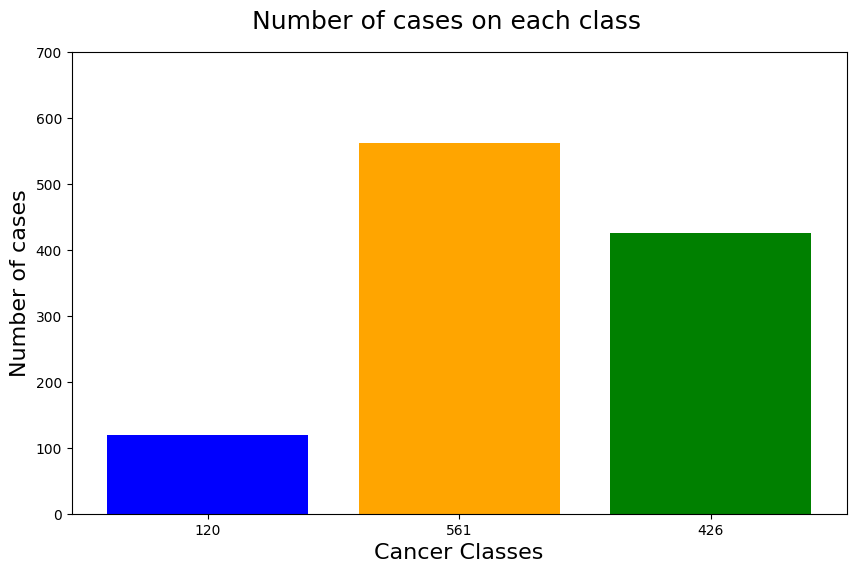

In [12]:
# define the bars colors
c = ['blue', 'orange', 'green']
# define the figure size
plt.rcParams["figure.figsize"] = (10,6)
# make the barchart
plt.bar(range(len(num_list)), num_list, tick_label=num_list, color = c)
# set the title and labels
plt.suptitle('Number of cases on each class', y=0.95, fontsize=18)
plt.xlabel('Cancer Classes', fontsize=16)
plt.ylabel('Number of cases', fontsize=16)
# set y-axis limit
plt.ylim([0, 700])
plt.show()

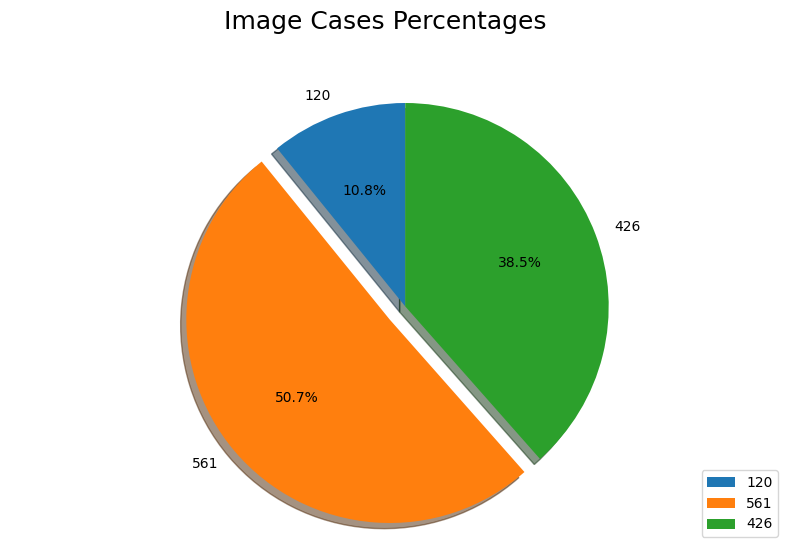

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(num_list, explode=explode, labels=num_list, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle('Image Cases Percentages', y=1, fontsize=18)
plt.legend(loc = 'lower right')

plt.show()

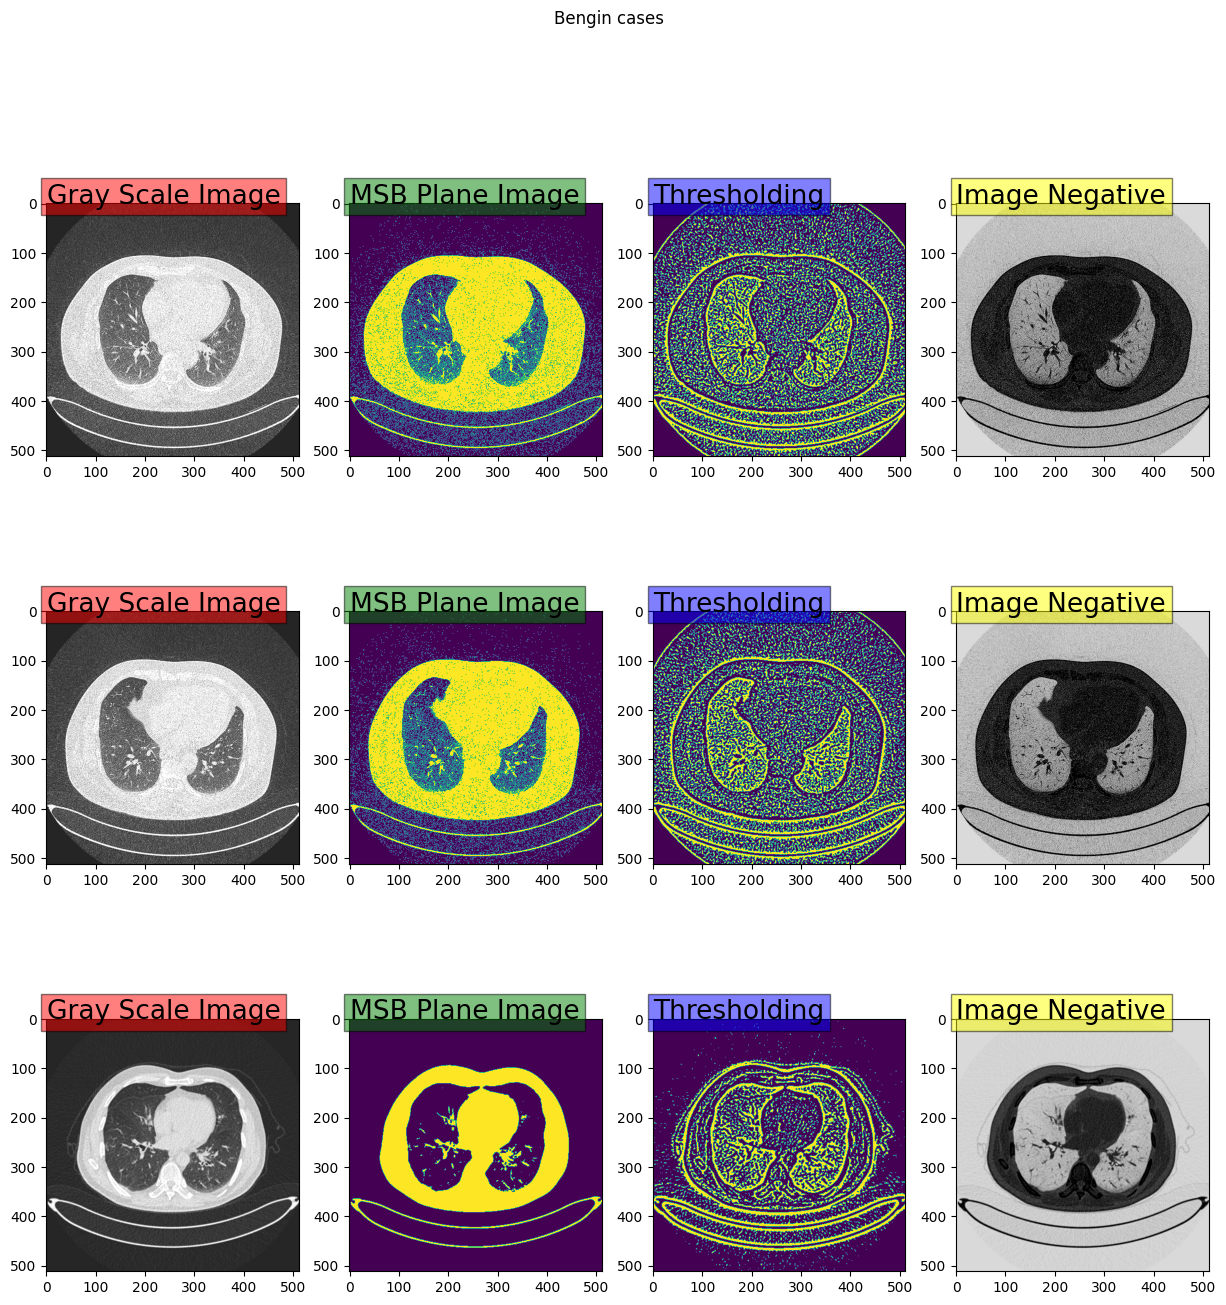

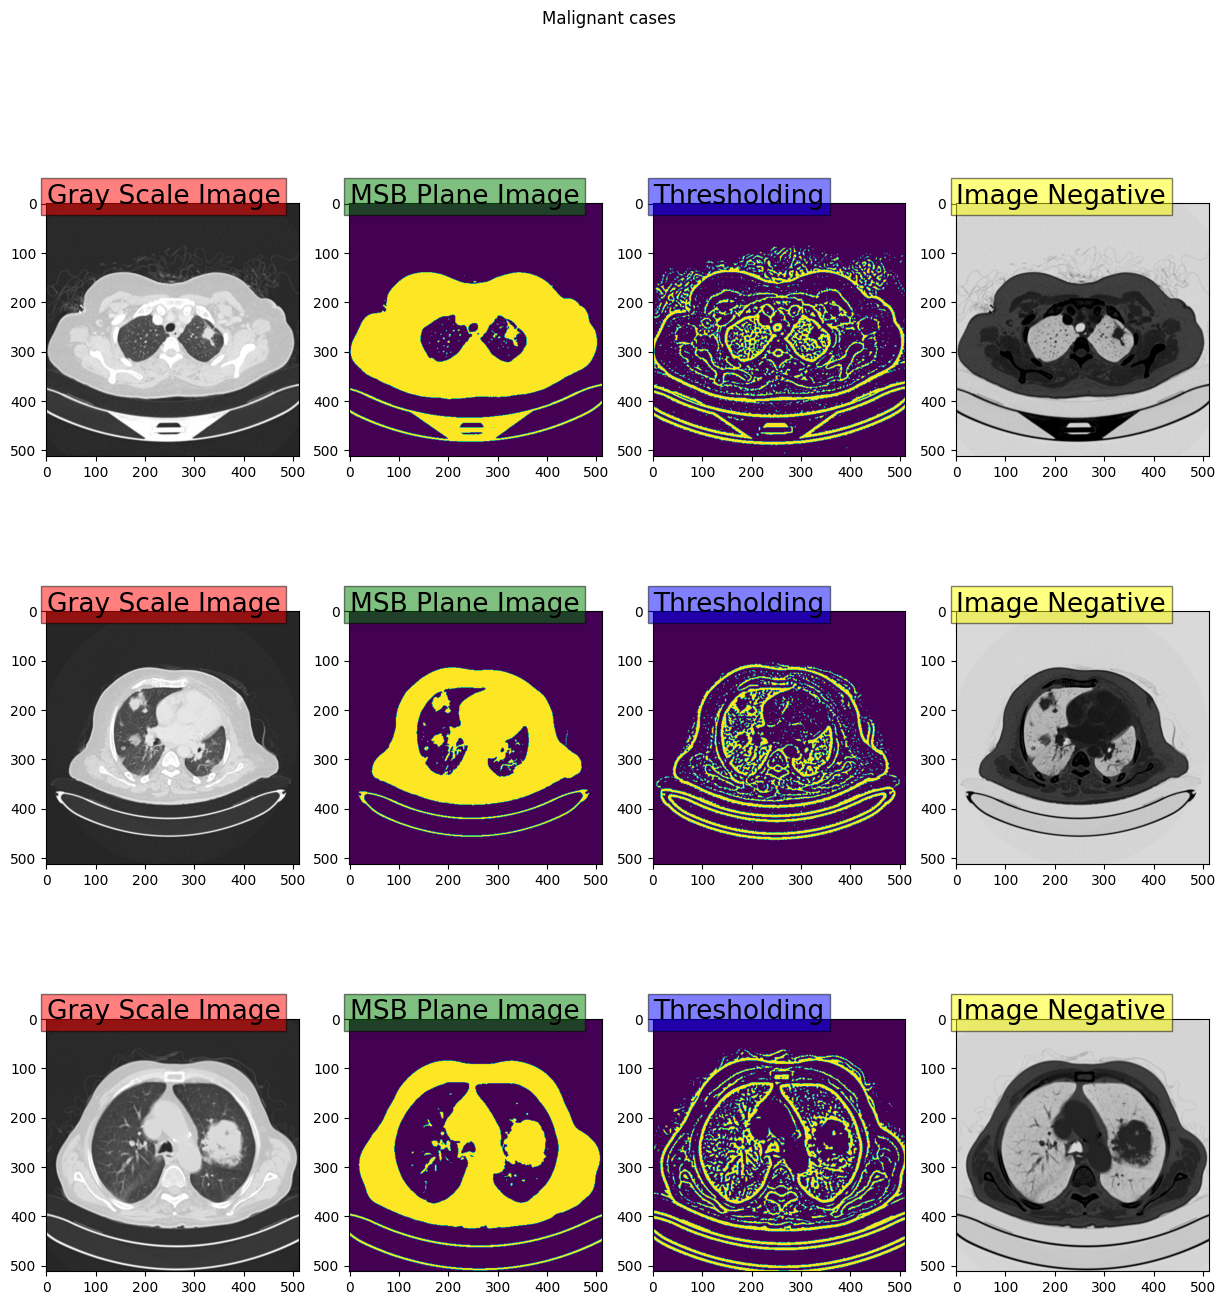

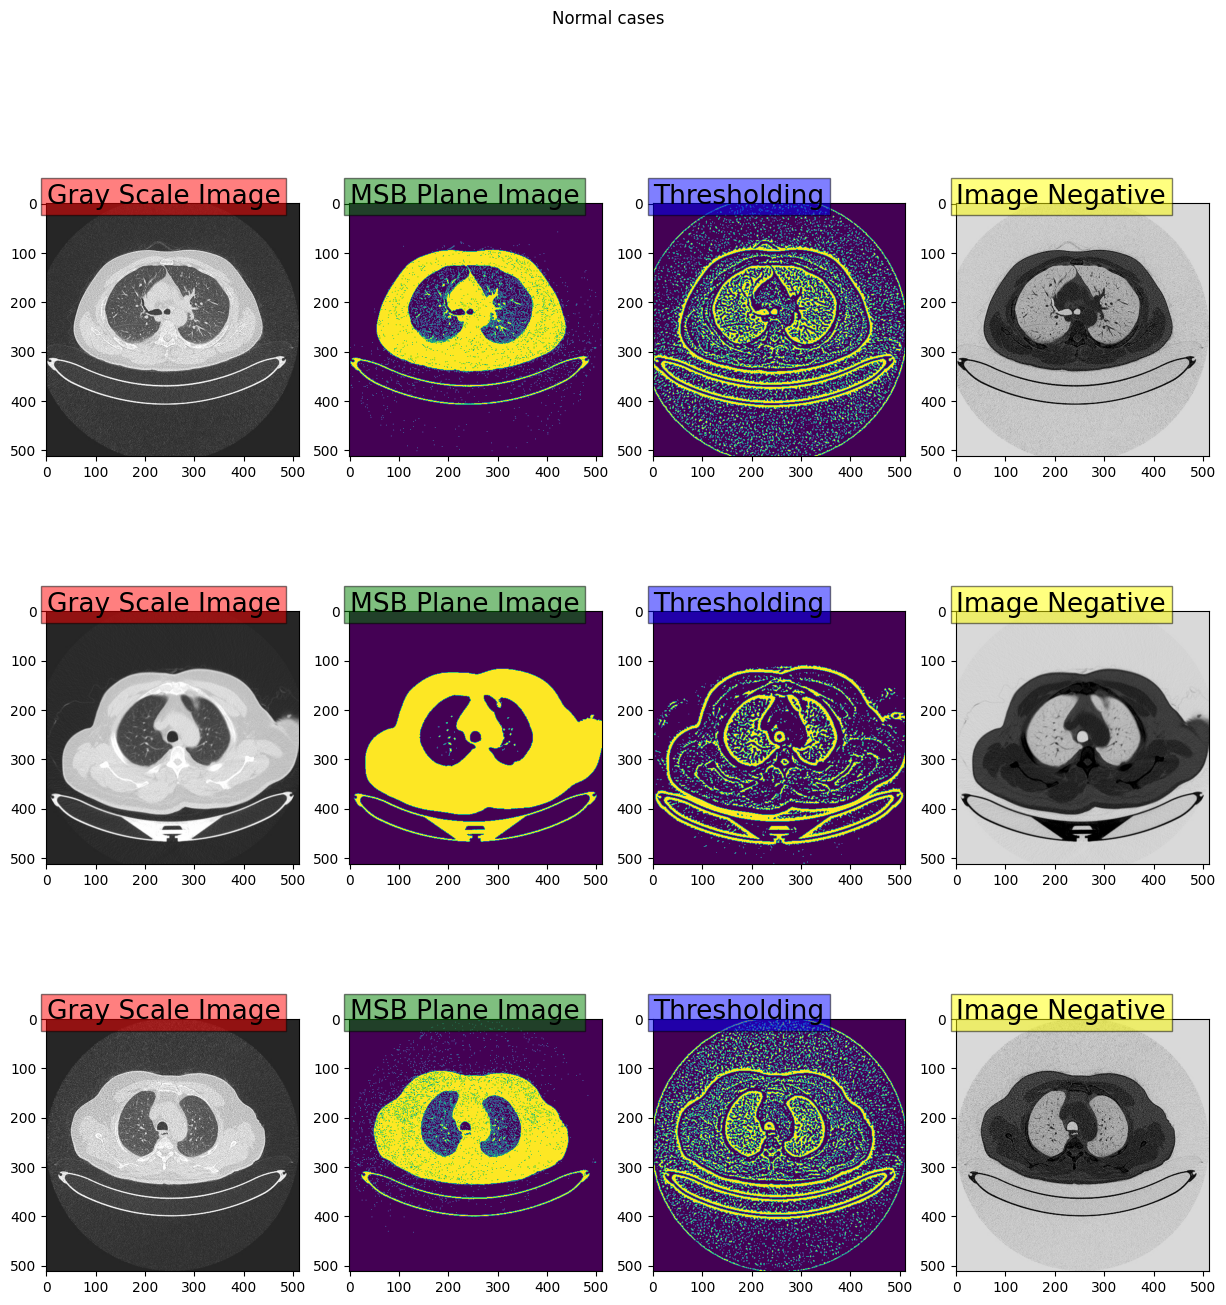

In [14]:
# Apply the filters on class of images
for i in label_dirs:
    # take 3 samples from each class to be proccessed
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 4, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join('/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset', i)
    class_num = label_dirs.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath)

        # Convert to grayscals
        gray = cv2.imread(filepath, 0)

        # Resizing images with the target image size
        img0 = cv2.resize(img, (128, 128))

        # Apply GaussianBlur to smooth the image (remove any spark noise that maybe affect the sharpening filters)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply Adaptive thresholding to get the high components (details or edges) in the image
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11, 4)
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)


        # Apply Bit Plane Slicing to select the image with highest details and neglect other planes
        lst = []
        for i in range(gray.shape[0]):
            for j in range(gray.shape[1]):
                lst.append(np.binary_repr(gray[i][j] ,width=8)) # width = no. of bits

        eight_bit_img = (np.array([int(i[0]) for i in lst],dtype = np.uint8) * 128).reshape(gray.shape[0],gray.shape[1])


        # Apply Image Negative to reverse the image from white to black or vise versa
        arr = np.array(gray)
        invert = np.array(img)
        Max = np.max(invert)
        for i in range(invert.shape[0]):
            for j in range(invert.shape[1]):
                invert[i, j] = Max - invert[i, j]

        # give a title for each image after applying the filter

        ax[cnt, 0].text(0.5, 0.5, 'Gray Scale Image', fontsize=19, bbox=dict(facecolor='red', alpha=0.5))
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].text(0.5, 0.5, 'MSB Plane Image', fontsize=19, bbox=dict(facecolor='green', alpha=0.5))
        ax[cnt, 1].imshow(eight_bit_img)
        ax[cnt, 2].text(0.5, 0.5, 'Thresholding', fontsize=19, bbox=dict(facecolor='blue', alpha=0.5))
        ax[cnt, 2].imshow(thresh)
        ax[cnt, 3].text(0.5, 0.5, 'Image Negative', fontsize=19, bbox=dict(facecolor='yellow', alpha=0.5))
        ax[cnt, 3].imshow(invert)
        cnt += 1
        if cnt == samples:
            break
plt.show()

In [15]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [16]:
label_dirs

['Bengin cases', 'Malignant cases', 'Normal cases']

In [17]:
import shutil

for label in label_dirs:
    img_paths = glob.glob(os.path.join(data_dir, label, "*.jpg"))


    random_seed = 42


    train_paths, rest_paths = train_test_split(img_paths, train_size=train_ratio, random_state=random_seed)
    val_paths, test_paths = train_test_split(rest_paths, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed)

    for phase, paths in zip(["train", "val", "test"], [train_paths, val_paths, test_paths]):
        phase_dir = os.path.join(out_dir, phase)
        if not os.path.exists(phase_dir):
            os.makedirs(phase_dir)

        label_dir = os.path.join(phase_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

        for path in paths:
            dst_path = os.path.join(label_dir, os.path.basename(path))
            shutil.copy(path, dst_path)

In [18]:
train_bingin = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/train/Bengin cases'
train_malignant = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/train/Malignant cases'
train_normal = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/train/Normal cases'

val_bingin = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/val/Bengin cases'
val_malignant = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/val/Malignant cases'
val_normal = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/val/Normal cases'

In [19]:
def create_augmentation_seq():
    augmentation_seq = iaa.Sequential([
      iaa.Rot90([1, 2, 3]),
      iaa.Fliplr(0.5),
      iaa.Affine(translate_px=iap.DiscreteUniform(-10, 10), scale=(0.9, 1.1)),
      iaa.CropAndPad(px=(-10, 10)),
      iaa.AdditiveGaussianNoise(scale=(0, 30)),
      iaa.LinearContrast((0.9, 1.1)),
    ])
    return augmentation_seq

In [20]:
def augment_and_save_images(input_path, output_path, num_augmented):
    img = Image.open(input_path)
    img_np = np.array(img)
    augmentation_seq = create_augmentation_seq()

    for i in range(num_augmented):
        aug_img_np = augmentation_seq(image=img_np)
        aug_img = Image.fromarray(aug_img_np)
        save_path = os.path.join(output_path, f"augmented_{i}_{os.path.basename(input_path)}")
        aug_img.save(save_path)

In [21]:
class_folders = [train_bingin, train_malignant, train_normal]

for class_folder in class_folders:
    image_paths = glob.glob(os.path.join(class_folder, "*.jpg"))

    for img_path in image_paths:
        augment_and_save_images(img_path, class_folder, num_augmented=4)

In [22]:
class_folders = [val_bingin, val_malignant, val_normal]

for class_folder in class_folders:
    image_paths = glob.glob(os.path.join(class_folder, "*.jpg"))

    for img_path in image_paths:
        augment_and_save_images(img_path, class_folder, num_augmented=4)

In [23]:
# train, val,test direction
train_dir = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/train'
test_dir = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/test'
val_dir = '/content/drive/MyDrive/Dataset/The IQ-OTHNCCD lung cancer dataset/val'

In [24]:
img_size  = 128
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(128, 128),
                                                                 batch_size = 32,
                                                                 shuffle = True)

val_generator = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                 image_size=(128, 128),
                                                                 batch_size = 32,
                                                                 shuffle = True)

test_generator = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 image_size=(128, 128),
                                                                 batch_size = 32,
                                                                 shuffle = True)

Found 3870 files belonging to 3 classes.
Found 830 files belonging to 3 classes.
Found 167 files belonging to 3 classes.


In [25]:
#  train data size
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [26]:
class_names = train_generator.class_names
print(class_names)

['Bengin cases', 'Malignant cases', 'Normal cases']


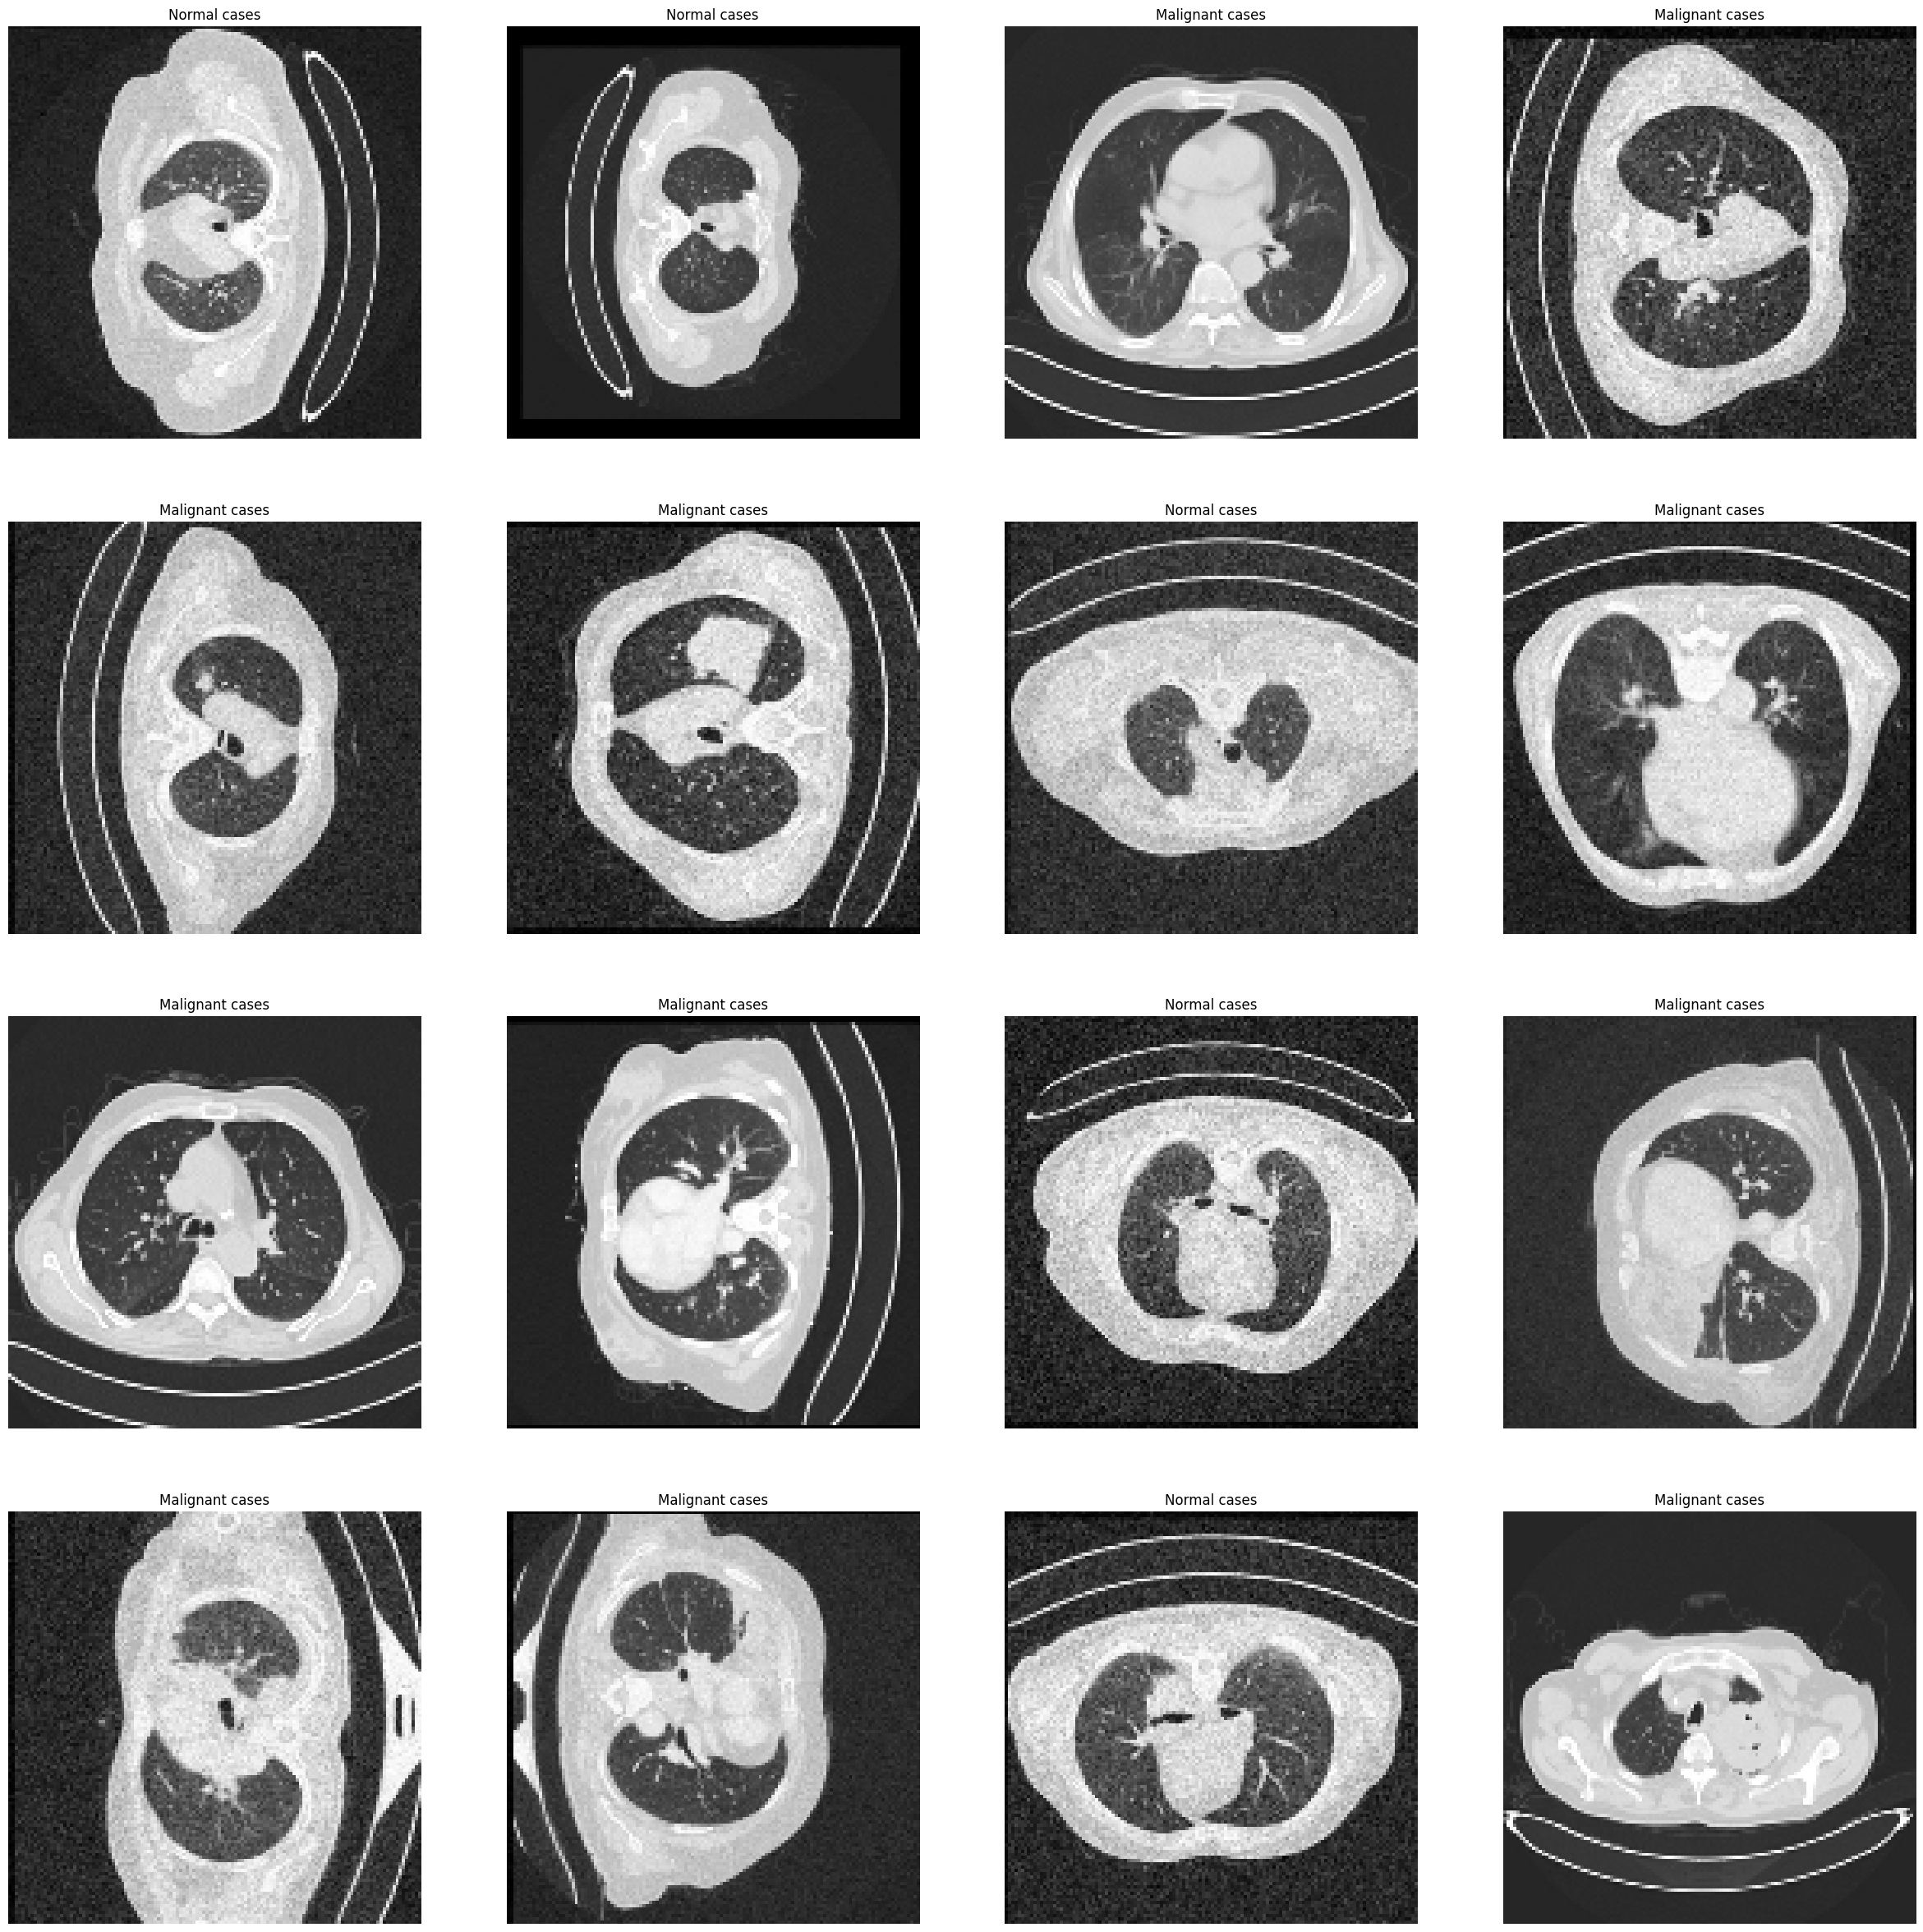

In [27]:
plt.figure(figsize = (30,30))

for images, labels in train_generator.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [28]:
image_batch

<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[24.75, 24.75, 24.75],
         [ 8.  ,  8.  ,  8.  ],
         [21.25, 21.25, 21.25],
         ...,
         [14.25, 14.25, 14.25],
         [23.25, 23.25, 23.25],
         [11.  , 11.  , 11.  ]],

        [[21.  , 21.  , 21.  ],
         [ 3.5 ,  3.5 ,  3.5 ],
         [16.5 , 16.5 , 16.5 ],
         ...,
         [ 8.75,  8.75,  8.75],
         [18.5 , 18.5 , 18.5 ],
         [25.  , 25.  , 25.  ]],

        [[36.  , 36.  , 36.  ],
         [31.75, 31.75, 31.75],
         [59.  , 59.  , 59.  ],
         ...,
         [13.25, 13.25, 13.25],
         [45.5 , 45.5 , 45.5 ],
         [40.  , 40.  , 40.  ]],

        ...,

        [[38.75, 38.75, 38.75],
         [43.  , 43.  , 43.  ],
         [22.25, 22.25, 22.25],
         ...,
         [25.25, 25.25, 25.25],
         [57.5 , 57.5 , 57.5 ],
         [46.75, 46.75, 46.75]],

        [[13.75, 13.75, 13.75],
         [19.5 , 19.5 , 19.5 ],
         [ 8.5 ,  8.5 ,  8.5 ],

In [29]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 253.25


**normalization**

In [30]:
def standard(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -1   # Between -1 to 1
    return image, label

In [31]:
train = train_generator.map(standard)
validation = val_generator.map(standard)

In [32]:
for normal_batch, train_label in train:
  print(normal_batch.shape)
  print(train_label.shape)
  break

(32, 128, 128, 3)
(32,)


In [33]:
train_label

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 0, 1, 1,
       0, 2, 1, 1, 2, 0, 1, 1, 1, 1], dtype=int32)>

In [34]:
for val_batch, val_label in validation:
  print(normal_batch.shape)
  print(train_label.shape)
  break

(32, 128, 128, 3)
(32,)


In [35]:
# max, min
# -1, +1
normal_image = normal_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(normal_image), np.max(normal_image))

-0.89215684 1.0


In [36]:
val_image = val_batch[0]
print(np.min(val_image), np.max(val_image))

-1.0 0.9941176


**CNN Modeling**

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
# Image size and batch size
img_size = (128, 128)
batch_size = 32

# Load MobileNet model without the top (fully connected) layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Replace 'num_classes' with the number of your classes

# Combine the base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)


17225924/17225924 [==============================] - 0s 0us/step


In [39]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

In [40]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

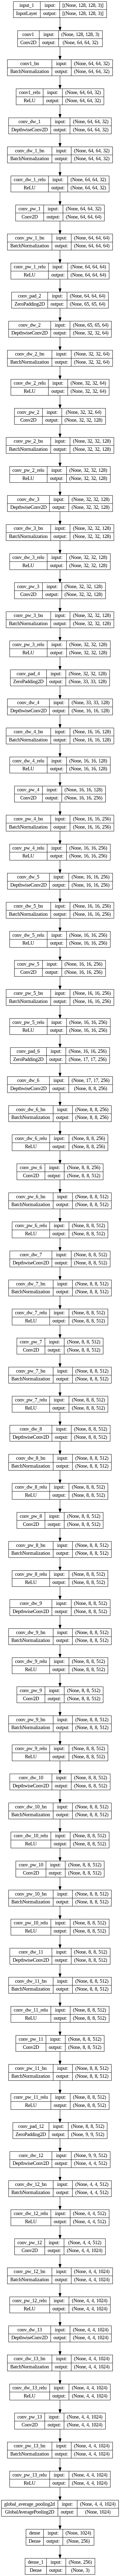

In [41]:
# Visualize the Layers of the Model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
history = model.fit(train_generator,
                    batch_size=62,
                    epochs=20,
                    validation_data=validation)

**Model Evaluate**

In [ ]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graghs(history, 'accuracy')

In [ ]:
plot_graghs(history, 'loss')

In [ ]:
test = test_generator.map(standard)

In [ ]:
result = model.evaluate(test)
print("Test loss, Test accuracy : ", result)